In [16]:
!pip install squarify
import squarify
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.colors
import plotly.graph_objects as go
from google.colab import drive
drive.mount('/content/drive')

# Set the search parameters
filename = 'ecommerce_retail.xlsx'
search_path = '/content/drive/My Drive/Colab Notebooks/Python/Dataset'
# Search for the file
file_path = None
for root, dirs, files in os.walk(search_path):
    if filename in files:
        file_path = os.path.join(root, filename)
        break
# Check if file is found and read it
if file_path:
    df = pd.read_excel(file_path)
    print(f"File found: {file_path}")
else:
    print("File not found. Please check the path and filename.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File found: /content/drive/My Drive/Colab Notebooks/Python/Dataset/ecommerce_retail.xlsx


# **Cleaning data**

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# Convert type
df['UnitPrice'] = df['UnitPrice'].astype(int)
df['CustomerID'] = df['CustomerID'].astype(int)

In [ ]:
# Re-check data type
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,int64
CustomerID,int64
Country,object
Total,int64


In [ ]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df = df.dropna(subset=['CustomerID'])

In [ ]:
# Check duplicated
print(df.duplicated().sum(), " duplicates")

5225  duplicates


In [ ]:
# Remove duplicated
df = df.drop_duplicates()

In [ ]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,2.885689,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.000000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.000000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.000000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.314654,1713.600303


Column 'Quantity' had negative value <br/>
Filter data where column 'Quantity' and 'UnitPrice' > 0, remove transaction with InvoiceNo start with 'C' character (Cancelled transaction)

In [ ]:
# Filter
df = df[
    (df['Quantity'] > 0) &
    (df['UnitPrice'] > 0) &
    (~df['InvoiceNo'].astype(str).str.startswith('C'))
]

# Re-check
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,304911.000000,304911,304911.000000,304911.000000
mean,10.255898,2011-07-08 14:45:08.094690048,3.317834,15297.045351
min,1.000000,2010-12-01 08:26:00,1.000000,12346.000000
25%,2.000000,2011-04-03 14:42:00,1.000000,13975.000000
50%,4.000000,2011-07-28 11:18:00,2.000000,15153.000000
75%,10.000000,2011-10-19 16:41:00,4.000000,16805.000000
max,80995.000000,2011-12-09 12:50:00,8142.000000,18287.000000
std,201.446073,NaN,25.186431,1711.528333


# **Calculating RFM**

In [3]:
last_purchase_date = df.groupby('CustomerID')['InvoiceDate'].max().reset_index(name='LastPurchaseDate')

# Create 'total' column:
df['Total'] = df['Quantity'] * df['UnitPrice']

# Specify the reference date for recency calculations
reference_date = df['InvoiceDate'].max()

# Calculate rfm
rfm_df = df.groupby('CustomerID').agg(
    # calculate recency
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    # calculate frequency
    Frequency=('InvoiceNo', 'nunique'),
    # calculate monetary
    Monetary=('Total', 'sum')
).reset_index()
rfm_df = last_purchase_date.merge(rfm_df, on='CustomerID', how='left')
rfm_df.shape

(4372, 5)

In [4]:
# RFM Scoring
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], q=5, labels=[1, 2, 3, 4, 5])

# Combine RFM scores into a single RFM score column
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)
print(rfm_df.head())

   CustomerID    LastPurchaseDate  Recency  Frequency  Monetary R_Score  \
0     12346.0 2011-01-18 10:17:00      325          2      0.00       1   
1     12347.0 2011-12-07 15:52:00        1          7   4310.00       5   
2     12348.0 2011-09-25 13:13:00       74          4   1797.24       2   
3     12349.0 2011-11-21 09:51:00       18          1   1757.55       4   
4     12350.0 2011-02-02 16:01:00      309          1    334.40       1   

  F_Score M_Score RFM_Score  
0       2       1       121  
1       4       5       545  
2       3       4       234  
3       1       4       414  
4       1       2       112  


# **Segmentation**





In [5]:
segmentation = {
    'Champions': ['555', '554', '544', '545', '454', '455', '445'],
    'Loyal Customers': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Potential Loyalist': ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'],
    'New Customers': ['512', '511', '422', '421', '412', '411', '311'],
    'Promising': ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313'],
    'Need Attention': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'About To Sleep': ['331', '321', '312', '221', '213', '231', '241', '251'],
    'At Risk': ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'],
    'Cannot Lose Them': ['155', '154', '144', '214', '215', '115', '114', '113'],
    'Hibernating customers': ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'],
    'Lost customers': ['111', '112', '121', '131', '141', '151']
}

# Map RFM scores to customer segments
def assign_segment(rfm_score):
    for segment, scores in segmentation.items():
        if rfm_score in scores:
            return segment
    return 'Other'

rfm_df['Segment'] = rfm_df['RFM_Score'].apply(assign_segment)
print(rfm_df.head())

   CustomerID    LastPurchaseDate  Recency  Frequency  Monetary R_Score  \
0     12346.0 2011-01-18 10:17:00      325          2      0.00       1   
1     12347.0 2011-12-07 15:52:00        1          7   4310.00       5   
2     12348.0 2011-09-25 13:13:00       74          4   1797.24       2   
3     12349.0 2011-11-21 09:51:00       18          1   1757.55       4   
4     12350.0 2011-02-02 16:01:00      309          1    334.40       1   

  F_Score M_Score RFM_Score         Segment  
0       2       1       121  Lost customers  
1       4       5       545       Champions  
2       3       4       234         At Risk  
3       1       4       414       Promising  
4       1       2       112  Lost customers  


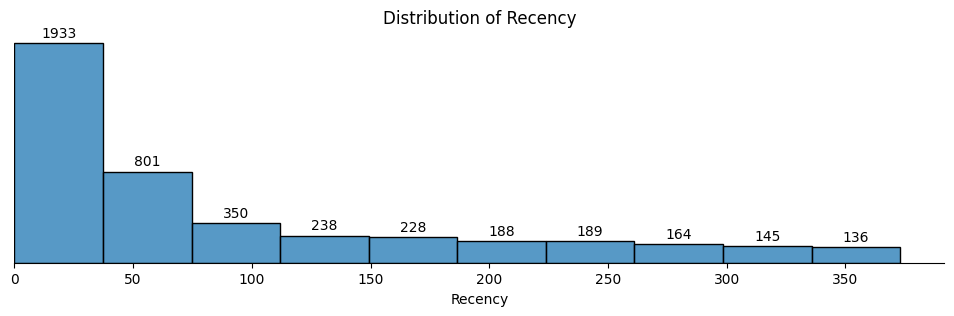

In [6]:
#Distribution of Recency
fig, ax = plt.subplots(figsize=(12, 3))
sns.histplot(data=rfm_df, x='Recency', bins =10, ax=ax)
ax.set_title('Distribution of Recency')
ax.set_xlim(left=0)
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2)
plt.show()

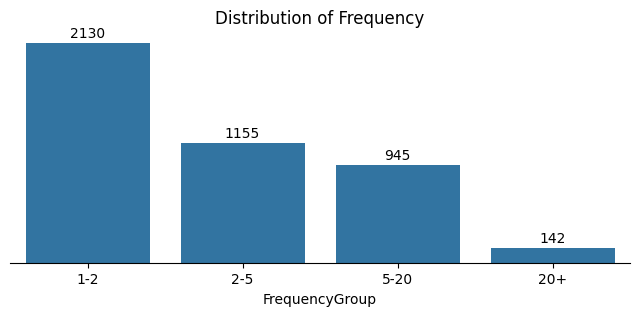

In [7]:
#Distribution of Frequency
binsF = [0, 2, 5, 20, np.inf]
labelsF = ['1-2', '2-5', '5-20', '20+']
rfm_df['FrequencyGroup'] = pd.cut(rfm_df['Frequency'], bins=binsF, labels=labelsF)
fig, ax = plt.subplots(figsize=(8, 3))
sns.countplot(x='FrequencyGroup', data=rfm_df, ax=ax)
ax.set_title('Distribution of Frequency')
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2)
plt.show()

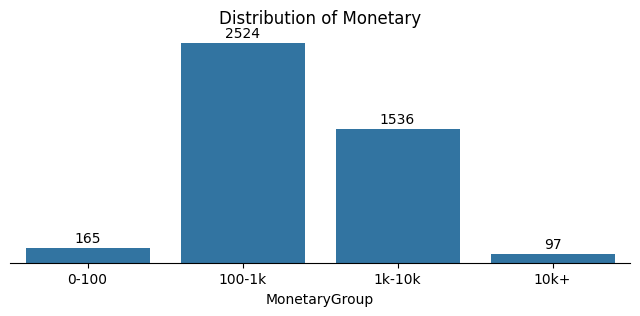

In [8]:
#Distribution of Monetary
binsM = [0, 100, 1000, 10000, np.inf]
labelsM = ['0-100', '100-1k', '1k-10k', '10k+']
rfm_df['MonetaryGroup'] = pd.cut(rfm_df['Monetary'], bins=binsM, labels=labelsM)
fig, ax = plt.subplots(figsize=(8, 3))
sns.countplot(x='MonetaryGroup', data=rfm_df, ax=ax)
ax.set_title('Distribution of Monetary')
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2)
plt.show()

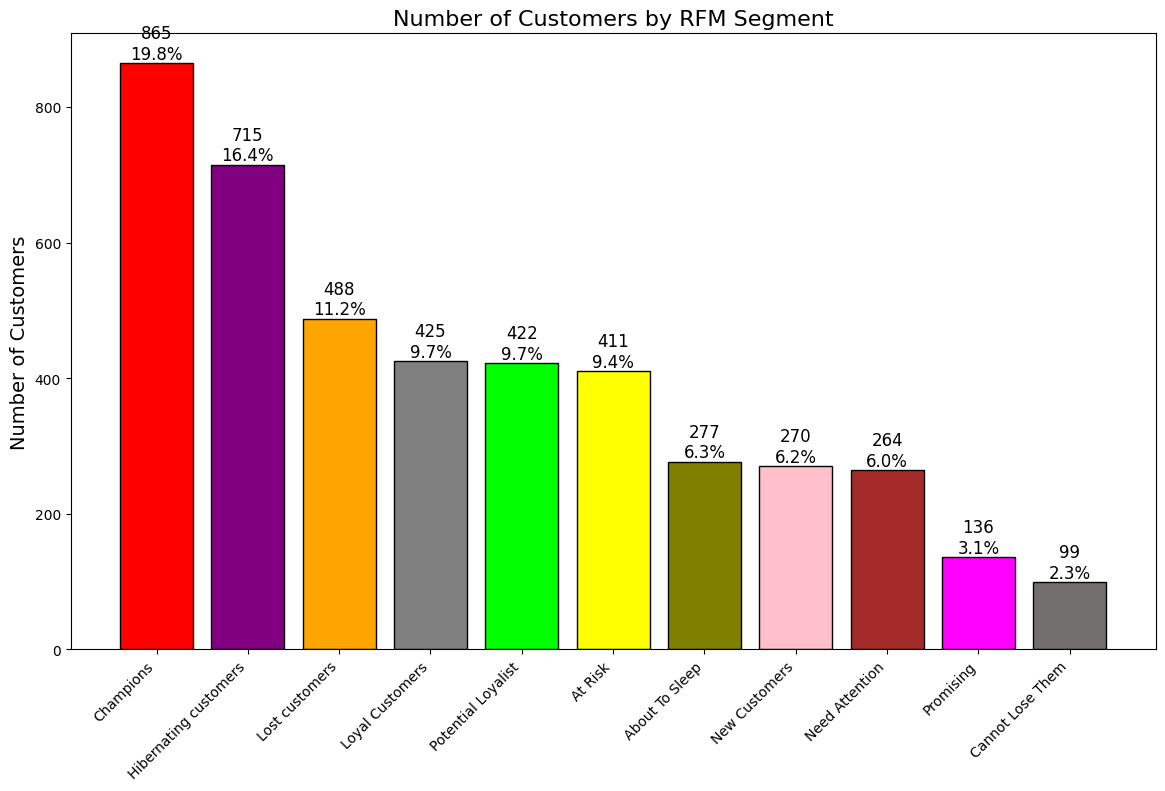

In [27]:
segment_colors = {
    'Champions': '#FF0000',
    'Loyal': '#00FFFF',
    'Potential Loyalist': '#00FF00',
    'At Risk': '#FFFF00',
    'Hibernating customers': '#800080',
    'Lost customers': '#FFA500',
    'Need Attention': '#A52A2A',
    'About To Sleep': '#808000',
    'New Customers': '#FFC0CB',
    'Promising': '#FF00FF',
    'Cannot Lose Them': '#736F6E'
}

# Calculate segment counts and percentage shares
segment_counts = rfm_df['Segment'].value_counts()
segment_shares = (segment_counts / segment_counts.sum()) * 100

# Create a bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Bar plot
bars = ax.bar(segment_counts.index,
              segment_counts.values,
              color=[segment_colors.get(segment, '#808080') for segment in segment_counts.index],
              edgecolor="black")

# Adding labels on top of bars
for bar, count, share in zip(bars, segment_counts.values, segment_shares.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f"{count:,}\n{share:.1f}%",  # Format the percentage with 1 decimal
            ha='center', va='bottom', fontsize=12)

# Title and labels
plt.title('Number of Customers by RFM Segment', fontsize=16)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Display the plot
plt.show()

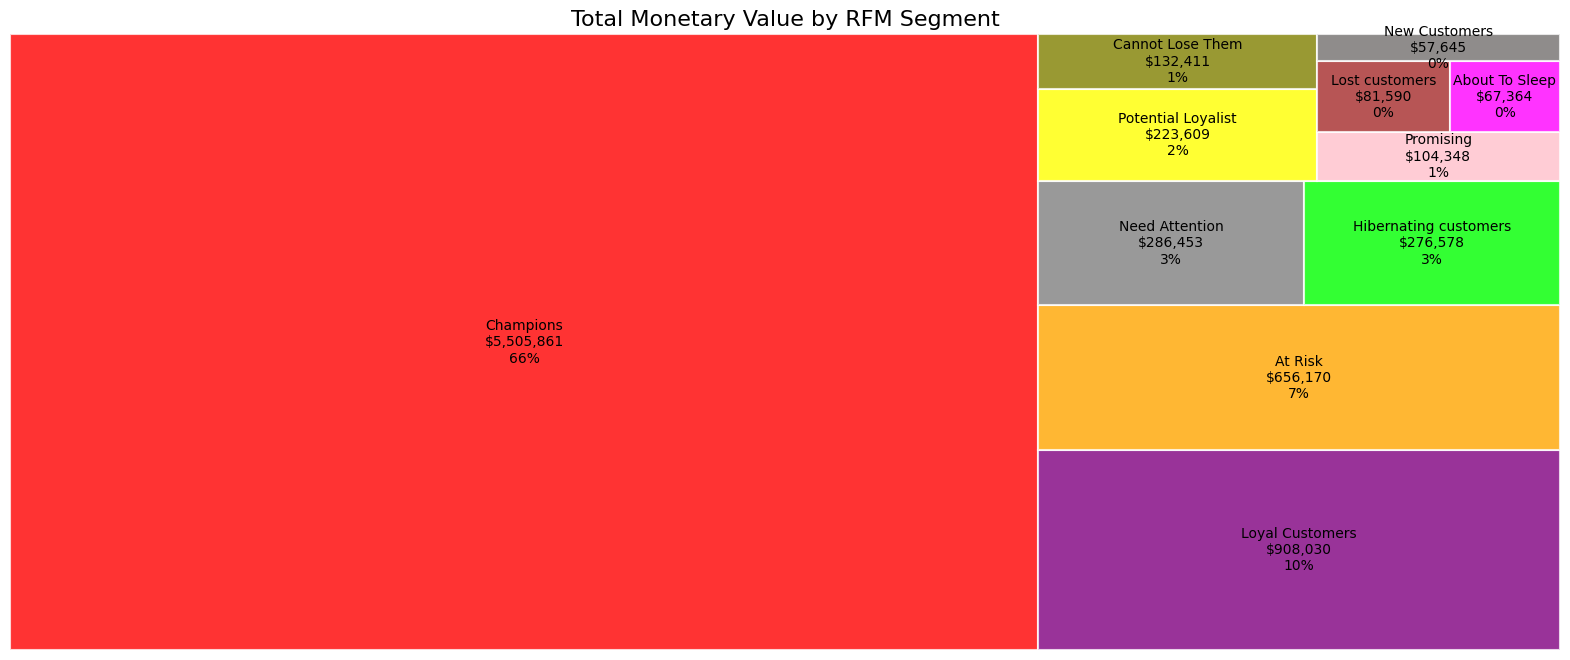

In [29]:
# % and Monetary values by Segment
segment_monetary = rfm_df.groupby('Segment')['Monetary'].sum().reset_index()
total_monetary = segment_monetary['Monetary'].sum()
segment_monetary['Percentage'] = segment_monetary['Monetary'] / total_monetary * 100

segment_monetary = segment_monetary.sort_values('Monetary', ascending=False)

# Create the treemap

fig, ax = plt.subplots(1, figsize=(20,8))
squarify.plot(sizes=segment_monetary['Monetary'],
              label=[f"{s}\n${int(m):,}\n{int(p)}%"
                     for s, m, p in zip(segment_monetary['Segment'],
                                        segment_monetary['Monetary'],
                                        segment_monetary['Percentage'])],
              color=[segment_colors.get(segment, '#808080') for segment in segment_counts.index],
              alpha=0.8,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white"))

plt.title('Total Monetary Value by RFM Segment', fontsize=16)
plt.axis('off')

plt.show()